# Calculus

In [1]:
# Imports
import numpy as np
import scipy.optimize as opt  # import root-finding algorithm
import sympy as sp  # Python toolbox for symbolic maths
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Toolbox for rendring 3D figures
from mpl_toolkits import mplot3d  # Toolbox for rendring 3D figures

#### Helper Functions

In [13]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
from matplotlib import gridspec
import ipywidgets as widgets  # interactive display
from ipywidgets import interact
%config InlineBackend.figure_format = 'retina'
# use NMA plot style
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")
my_layout = widgets.Layout()

fig_w, fig_h = 12, 4.5
my_fontsize = 16
my_params = {'axes.labelsize': my_fontsize,
          'axes.titlesize': my_fontsize,
          'figure.figsize': [fig_w, fig_h],
          'font.size': my_fontsize,
          'legend.fontsize': my_fontsize-4,
          'lines.markersize': 8.,
          'lines.linewidth': 2.,
          'xtick.labelsize': my_fontsize-2,
          'ytick.labelsize': my_fontsize-2}

plt.rcParams.update(my_params)
my_layout = widgets.Layout()

In [3]:
def Exact_Integrate_and_Fire(I,t):
  """
    Args:
      I  : Input Current
      t : time
    Returns:
      Spike : Spike Count
      Spike_time : Spike time
      V_exact : Exact membrane potential
  """

  Spike = 0
  tau_m = 10
  R = 10
  t_isi = 0
  V_reset = E_L = -75
  V_exact = V_reset * np.ones(len(t))
  V_th = -50
  Spike_time = []

  for i in range(0, len(t)):

    V_exact[i] = E_L + R*I + (V_reset - E_L - R*I) * np.exp(-(t[i]-t_isi)/tau_m)

    # Threshold Reset
    if V_exact[i] > V_th:
        V_exact[i-1] = 0
        V_exact[i] = V_reset
        t_isi = t[i]
        Spike = Spike+1
        Spike_time = np.append(Spike_time, t[i])

  return Spike, Spike_time, V_exact

In [4]:
# @title Plotting Functions
def move_sympyplot_to_axes(p, ax):
    backend = p.backend(p)
    backend.ax = ax
    backend.process_series()
    backend.ax.spines['right'].set_color('none')
    backend.ax.spines['bottom'].set_position('zero')
    backend.ax.spines['top'].set_color('none')
    plt.close(backend.fig)


def plot_functions(function, show_derivative, show_integral):

  # For sympy we first define our symbolic variable
  x, y, z, t, f = sp.symbols('x y z t f')

  # We define our function
  if function == 'Linear':
    f = -2*t
    name = r'$-2t$'
  elif function == 'Parabolic':
    f =  t**2
    name = r'$t^2$'
  elif function == 'Exponential':
    f =  sp.exp(t)
    name = r'$e^t$'
  elif function == 'Sine':
    f =  sp.sin(t)
    name = r'$sin(t)$'
  elif function == 'Sigmoid':
    f = 1/(1 + sp.exp(-(t-5)))
    name = r'$\frac{1}{1+e^{-(t-5)}}$'

  if show_derivative and not show_integral:
    # Calculate the derivative of sin(t) as a function of t
    diff_f = sp.diff(f)
    print('Derivative of', f, 'is ', diff_f)

    p1 = sp.plot(f, diff_f, show=False)
    p1[0].line_color='r'
    p1[1].line_color='b'
    p1[0].label='Function'
    p1[1].label='Derivative'
    p1.legend=True
    p1.title = 'Function = ' + name + '\n'
    p1.show()
  elif show_integral and not show_derivative:

    int_f = sp.integrate(f)
    int_f = int_f - int_f.subs(t, -10)
    print('Integral of', f, 'is ', int_f)


    p1 = sp.plot(f, int_f, show=False)
    p1[0].line_color='r'
    p1[1].line_color='g'
    p1[0].label='Function'
    p1[1].label='Integral'
    p1.legend=True
    p1.title = 'Function = ' + name + '\n'
    p1.show()


  elif show_integral and show_derivative:

    diff_f = sp.diff(f)
    print('Derivative of', f, 'is ', diff_f)

    int_f = sp.integrate(f)
    int_f = int_f - int_f.subs(t, -10)
    print('Integral of', f, 'is ', int_f)

    p1 = sp.plot(f, diff_f, int_f, show=False)
    p1[0].line_color='r'
    p1[1].line_color='b'
    p1[2].line_color='g'
    p1[0].label='Function'
    p1[1].label='Derivative'
    p1[2].label='Integral'
    p1.legend=True
    p1.title = 'Function = ' + name + '\n'
    p1.show()

  else:

    p1 = sp.plot(f, show=False)
    p1[0].line_color='r'
    p1[0].label='Function'
    p1.legend=True
    p1.title = 'Function = ' + name + '\n'
    p1.show()


def plot_alpha_func(t, f, df_dt):

  plt.figure()
  plt.subplot(2,1,1)
  plt.plot(t, f, 'r', label='Alpha function')
  plt.xlabel('Time (au)')
  plt.ylabel('Voltage')
  plt.title('Alpha function (f(t))')
  #plt.legend()

  plt.subplot(2,1,2)
  plt.plot(t, df_dt, 'b', label='Derivative')
  plt.title('Derivative of alpha function')
  plt.xlabel('Time (au)')
  plt.ylabel('df/dt')
  #plt.legend()


def plot_charge_transfer(t, PSP, numerical_integral):

  fig, axes = plt.subplots(1, 2)

  axes[0].plot(t, PSP)
  axes[0].set(xlabel = 't', ylabel = 'PSP')

  axes[1].plot(t, numerical_integral)
  axes[1].set(xlabel = 't', ylabel = 'Charge Transferred')

In [5]:
def plot_dPdt(alpha=.3):
  """ Plots change in population over time
    Args:
      alpha: Birth Rate
    Returns:
      A figure two panel figure
      left panel: change in population as a function of population
      right panel: membrane potential as a function of time
  """

  with plt.xkcd():
    time=np.arange(0, 10 ,0.01)
    fig = plt.figure(figsize=(12,4))
    gs = gridspec.GridSpec(1, 2)

    ## dpdt as a fucntion of p
    plt.subplot(gs[0])
    plt.plot(np.exp(alpha*time), alpha*np.exp(alpha*time))
    plt.xlabel(r'Population $p(t)$ (millions)')
    plt.ylabel(r'$\frac{d}{dt}p(t)=\alpha p(t)$')

    ## p exact solution
    plt.subplot(gs[1])
    plt.plot(time, np.exp(alpha*time))
    plt.ylabel(r'Population $p(t)$ (millions)')
    plt.xlabel('time (years)')
    plt.show()


def plot_V_no_input(V_reset=-75):
  """
    Args:
      V_reset: Reset Potential
    Returns:
      A figure two panel figure
      left panel: change in membrane potential as a function of membrane potential
      right panel: membrane potential as a function of time
  """
  E_L=-75
  tau_m=10
  t=np.arange(0,100,0.01)
  V= E_L+(V_reset-E_L)*np.exp(-(t)/tau_m)
  V_range=np.arange(-90,0,1)
  dVdt=-(V_range-E_L)/tau_m

  with plt.xkcd():
    time=np.arange(0, 10, 0.01)
    fig = plt.figure(figsize=(12, 4))
    gs = gridspec.GridSpec(1, 2)

    plt.subplot(gs[0])
    plt.plot(V_range,dVdt)
    plt.hlines(0,min(V_range),max(V_range), colors='black', linestyles='dashed')
    plt.vlines(-75, min(dVdt), max(dVdt), colors='black', linestyles='dashed')
    plt.plot(V_reset,-(V_reset - E_L)/tau_m, 'o', label=r'$V_{reset}$')
    plt.text(-50, 1, 'Positive')
    plt.text(-50, -2, 'Negative')
    plt.text(E_L - 1, max(dVdt), r'$E_L$')
    plt.legend()
    plt.xlabel('Membrane Potential V (mV)')
    plt.ylabel(r'$\frac{dV}{dt}=\frac{-(V(t)-E_L)}{\tau_m}$')

    plt.subplot(gs[1])
    plt.plot(t,V)
    plt.plot(t[0],V_reset,'o')
    plt.ylabel(r'Membrane Potential $V(t)$ (mV)')
    plt.xlabel('time (ms)')
    plt.ylim([-95, -60])

    plt.show()


## LIF PLOT
def plot_IF(t, V,I,Spike_time):
  """
    Args:
      t  : time
      V  : membrane Voltage
      I  : Input
      Spike_time : Spike_times
    Returns:
      figure with three panels
      top panel: Input as a function of time
      middle panel: membrane potential as a function of time
      bottom panel: Raster plot
  """

  with plt.xkcd():
    fig = plt.figure(figsize=(12, 4))
    gs = gridspec.GridSpec(3, 1,  height_ratios=[1, 4, 1])

    # PLOT OF INPUT
    plt.subplot(gs[0])
    plt.ylabel(r'$I_e(nA)$')
    plt.yticks(rotation=45)
    plt.hlines(I,min(t),max(t),'g')
    plt.ylim((2, 4))
    plt.xlim((-50, 1000))

    # PLOT OF ACTIVITY
    plt.subplot(gs[1])
    plt.plot(t,V)
    plt.xlim((-50, 1000))
    plt.ylabel(r'$V(t)$(mV)')

    # PLOT OF SPIKES
    plt.subplot(gs[2])
    plt.ylabel(r'Spike')
    plt.yticks([])
    plt.scatter(Spike_time, 1 * np.ones(len(Spike_time)), color="grey", marker=".")
    plt.xlim((-50, 1000))
    plt.xlabel('time(ms)')
    plt.show()


## Plotting the differential Equation
def plot_dVdt(I=0):
  """
    Args:
      I  : Input Current
    Returns:
      figure of change in membrane potential as a function of membrane potential
  """

  with plt.xkcd():
    E_L = -75
    tau_m = 10
    V = np.arange(-85, 0, 1)
    g_L = 10.
    fig = plt.figure(figsize=(6, 4))

    plt.plot(V,(-(V-E_L) + I*10) / tau_m)
    plt.hlines(0, min(V), max(V), colors='black', linestyles='dashed')
    plt.xlabel('V (mV)')
    plt.ylabel(r'$\frac{dV}{dt}$')
    plt.show()

In [19]:
# @title Helper functions
def plot_Stuart_Landa(t, x, y, s):
  """
    Args:
      t  : time
      x  : x
      y  : y
      s : input
    Returns:
      figure with two panels
      top panel: Input as a function of time
      bottom panel: x
  """

  with plt.xkcd():
    fig = plt.figure(figsize=(14, 4))
    gs = gridspec.GridSpec(2, 2,  height_ratios=[1, 4], width_ratios=[4, 1])

    # PLOT OF INPUT
    plt.subplot(gs[0])
    plt.ylabel(r'$s$')
    plt.plot(t, s, 'g')
    #plt.ylim((2,4))

    # PLOT OF ACTIVITY
    plt.subplot(gs[2])
    plt.plot(t ,x)
    plt.ylabel(r'x')
    plt.xlabel(r't')
    plt.subplot(gs[3])
    plt.plot(x,y)
    plt.plot(x[0], y[0],'go')
    plt.xlabel(r'x')
    plt.ylabel(r'y')
    plt.show()


def Euler_Stuart_Landau(s,time,dt,lamba=0.1,gamma=1,k=25):
  """
  Args:
    I: Input
    time: time
    dt: time-step
  """

  n = len(time)
  omega = 4 * 2*np.pi
  x = np.zeros(n)
  y = np.zeros(n)
  x[0] = 1
  y[0] = 1

  for i in range(n-1):
    dx = lamba*x[i] - omega*y[i] - gamma*(x[i]*x[i] + y[i]*y[i])*x[i] + k*s[i]
    x[i+1] = x[i] + dt*dx
    dy = lamba*y[i] + omega*x[i] - gamma*(x[i]*x[i] + y[i]*y[i])*y[i]
    y[i+1] = y[i] + dt*dy

  return x, y

#### Ex1 Postsynaptic Potential Alpha Function

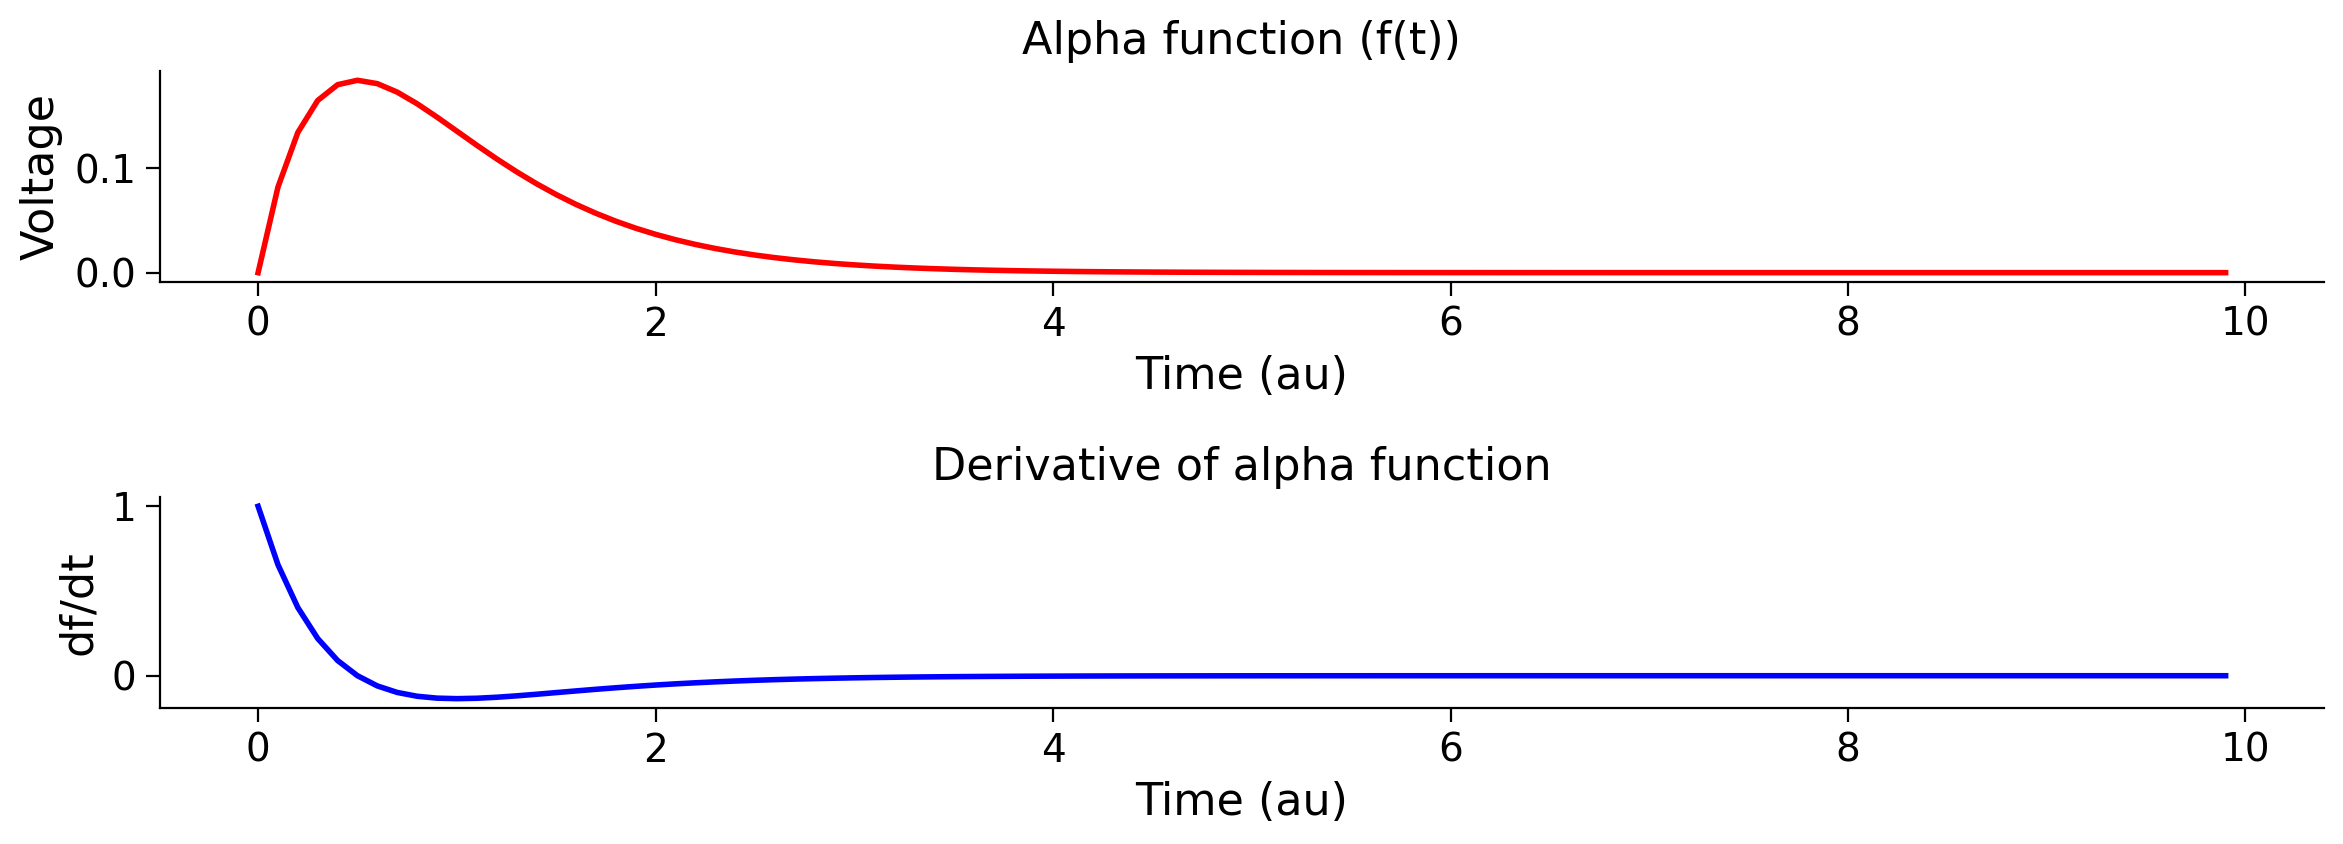

In [6]:
# Define time, time constant
t = np.arange(0, 10, .1)
tau = 0.5

# Compute alpha function
f = t * np.exp(-t/tau)

# Define u(t), v(t)
u_t = t
v_t = np.exp(-t/tau)

# Define du/dt, dv/dt
du_dt = 1
dv_dt = -1/tau * np.exp(-t/tau)

# Define full derivative
df_dt = du_dt * v_t + u_t * dv_dt

# Visualize
plot_alpha_func(t, f, df_dt)

In [7]:
# For sympy we first define our symbolic variables
f, t = sp.symbols('f, t')

# Function definition (sigmoid)
f = 1/(1 + sp.exp(-(t-5)))

# Get the derivative
diff_f = sp.diff(f)

# Print the resulting function
print('Derivative of', f, 'is ', diff_f)

Derivative of 1/(exp(5 - t) + 1) is  exp(5 - t)/(exp(5 - t) + 1)**2


#### Demo 1: Rate and Gain

In [8]:
def compute_rate_and_gain(I, a, theta, current_timestep):
  """ Compute rate and gain of neuron based on parameters

  Args:
    I (ndarray): different possible values of the current
    a (scalar): parameter of the transfer function
    theta (scalar): parameter of the transfer function
    current_timestep (scalar): the time we're using to take steps

  Returns:
    (ndarray, ndarray): rate and gain for each possible value of I
  """

  # Compute rate
  rate = (1+np.exp(-a*(I-theta)))**-1 - (1+np.exp(a*theta))**-1

  # Compute gain using a numerical derivative
  gain = (rate[1:] - rate[0:-1])/current_timestep

  return rate, gain

def plot_rate_and_gain(a, theta, I_mean):

  current_timestep = 0.1

  # Compute I
  I = np.arange(0, 8, current_timestep)

  rate, gain = compute_rate_and_gain(I, a, theta, current_timestep)
  I_1 = I_mean - current_timestep/2
  rate_1 = (1+np.exp(-a*(I_1-theta)))**-1 - (1+np.exp(a*theta))**-1
  I_2 = I_mean + current_timestep/2
  rate_2 = (1+np.exp(-a*(I_2-theta)))**-1 - (1+np.exp(a*theta))**-1

  input_range = I_2-I_1
  output_range = rate_2 - rate_1

  # Visualize rate and gain
  plt.subplot(1,2,1)
  plt.plot(I,rate)
  plt.plot([I_1,I_1],[0, rate_1],color='r')
  plt.plot([0,I_1],[rate_1, rate_1],color='b')
  plt.plot([I_2,I_2],[0, rate_2],color='r')
  plt.plot([0,I_2],[rate_2, rate_2],color='b')
  plt.xlim([0, 8])
  low, high = plt.ylim()
  plt.ylim([0, high])

  plt.xlabel('Injected current (au)')
  plt.ylabel('Output firing rate (normalized)')
  plt.title('Transfer function')

  plt.text(2, 1.3, 'Output-Input Ratio =' + str(np.round(1000*output_range/input_range)/1000), style='italic',
      bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
  plt.subplot(1,2,2)
  plt.plot(I[0:-1], gain)
  plt.plot([I_mean, I_mean],[0,0.6],color='r')
  plt.xlabel('Injected current (au)')
  plt.ylabel('Gain')
  plt.title('Gain')
  plt.xlim([0, 8])
  low, high = plt.ylim()
  plt.ylim([0, high])

_ = widgets.interact(plot_rate_and_gain, a = (0.5, 2.0, .02), theta=(1.2,4.0,0.1), I_mean= (0.5,8.0,0.1))

interactive(children=(FloatSlider(value=1.24, description='a', max=2.0, min=0.5, step=0.02), FloatSlider(value…

#### Demo 2: Riemann Sum

In [9]:
# @markdown Run this cell to enable the widget!
def riemann_sum_demo(dt = 0.5):
  step_size = 0.1
  min_val = 0.
  max_val = 10.
  tx = np.arange(min_val, max_val, step_size)

  # Our function
  ftn = tx**2 - tx + 1
  # And the integral analytical formula calculates using sympy
  int_ftn = tx**3/3 - tx**2/2 + tx

  # Numerical integration of f(t) using Riemann Sum
  n = int((max_val-min_val)/dt)
  r_tx = np.zeros(n)
  fun_value = np.zeros(n)
  for ii in range(n):
    a = min_val+ii*dt
    fun_value[ii] = a**2 - a + 1
    r_tx[ii] = a;

  # Riemann sum is just cumulative sum of the fun_value multiplied by the
  r_sum = np.cumsum(fun_value)*dt
  with plt.xkcd():
    plt.figure(figsize=(20,5))
    ax = plt.subplot(1,2,1)
    plt.plot(tx,ftn,label='Function')

    for ii in range(n):
      plt.plot([r_tx[ii], r_tx[ii], r_tx[ii]+dt, r_tx[ii]+dt], [0, fun_value[ii], fun_value[ii], 0] ,color='r')

    plt.xlabel('Time (au)')
    plt.ylabel('f(t)')
    plt.title('f(t)')
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(tx,int_ftn,label='Analytical')
    plt.plot(r_tx+dt,r_sum,color = 'r',label='Riemann Sum')
    plt.xlabel('Time (au)')
    plt.ylabel('int(f(t))')
    plt.title('Integral of f(t)')
    plt.grid()
    plt.legend()
    plt.show()


_ = widgets.interact(riemann_sum_demo, dt = (0.1, 1., .02))

interactive(children=(FloatSlider(value=0.5, description='dt', max=1.0, min=0.1, step=0.02), Output()), _dom_c…

#### Ex2 Charge Transfer with Excitatory Input

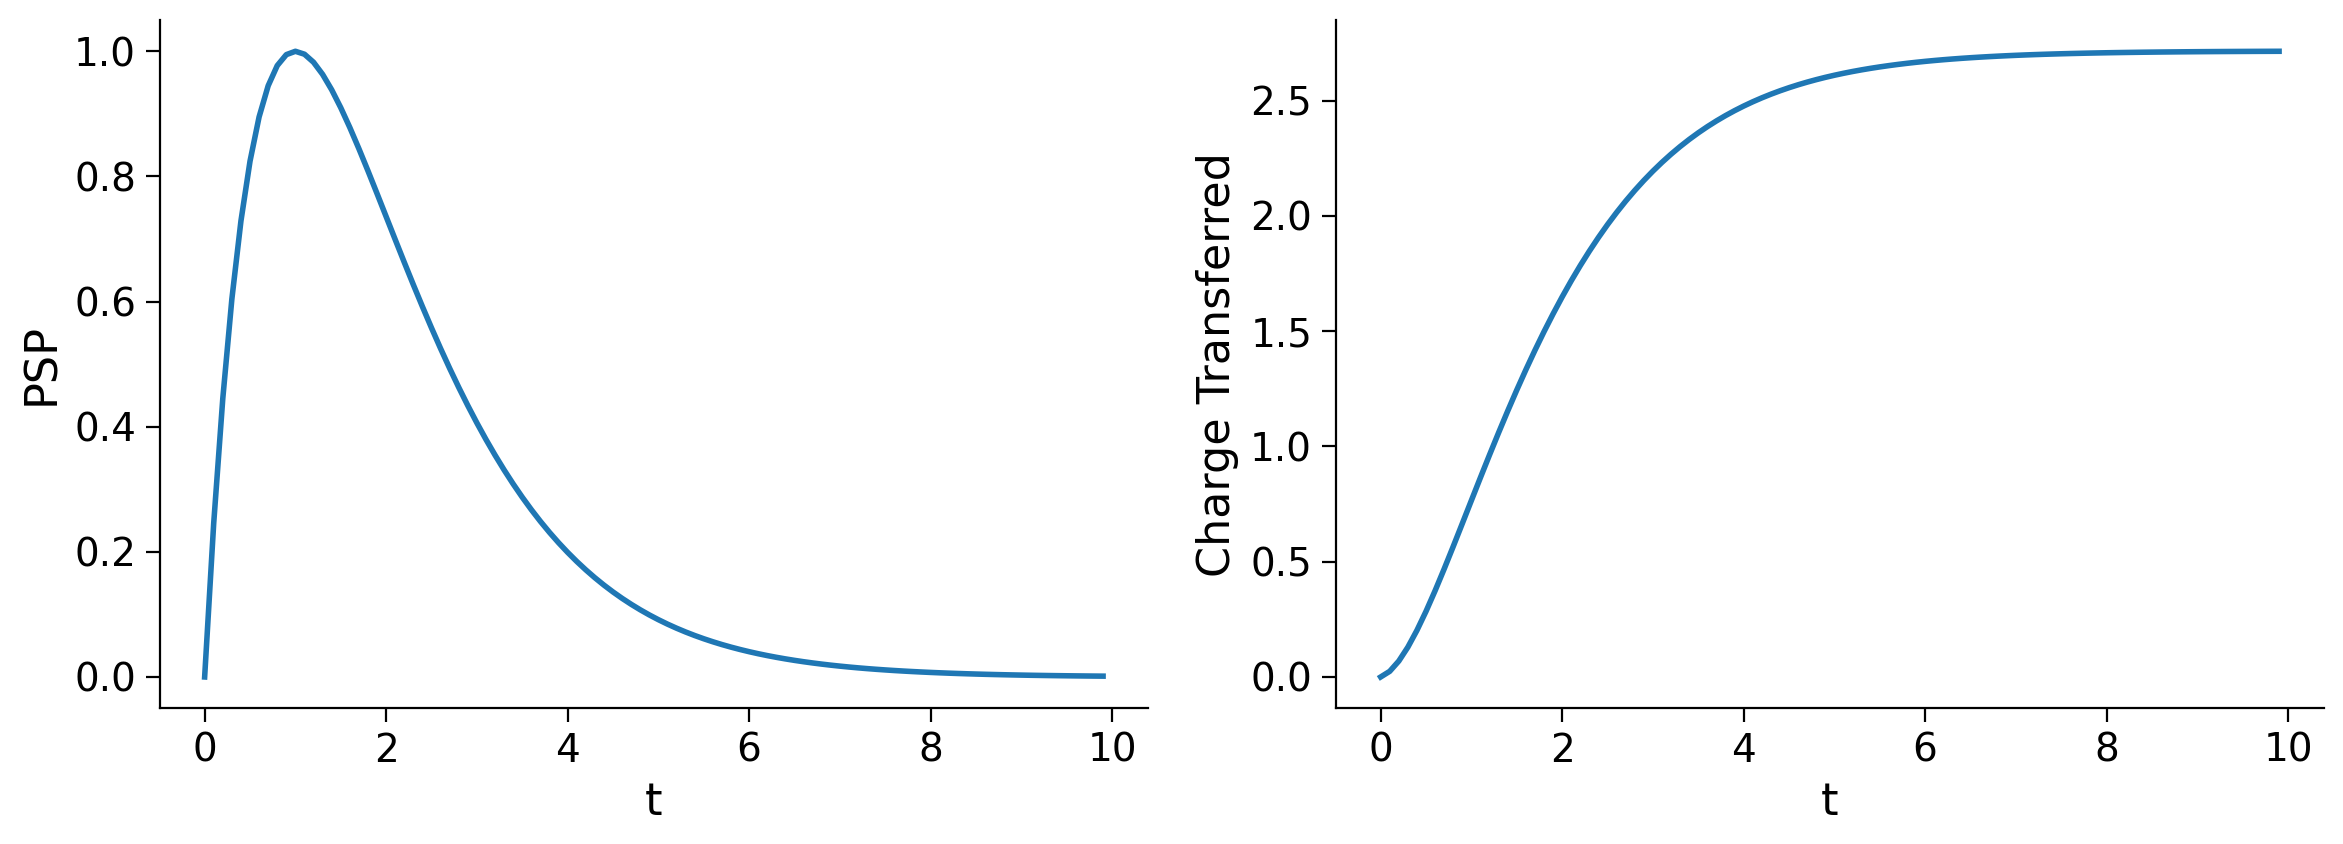

In [10]:
# Set up parameters
J = 1
tau_s = 1
t_sp = 1
dt = .1
t = np.arange(0, 10, dt)

# Code PSP formula
PSP = J * t * np.exp(-(t - t_sp)/tau_s)

# Compute numerical integral
# We already have PSP at every time step (height of rectangles). We need to
#.  multiply by width of rectangles (dt) to get areas
rectangle_areas = PSP * dt

# Cumulatively sum rectangles (hint: use np.cumsum)
numerical_integral = np.cumsum(rectangle_areas)

# Visualize
plot_charge_transfer(t, PSP, numerical_integral)

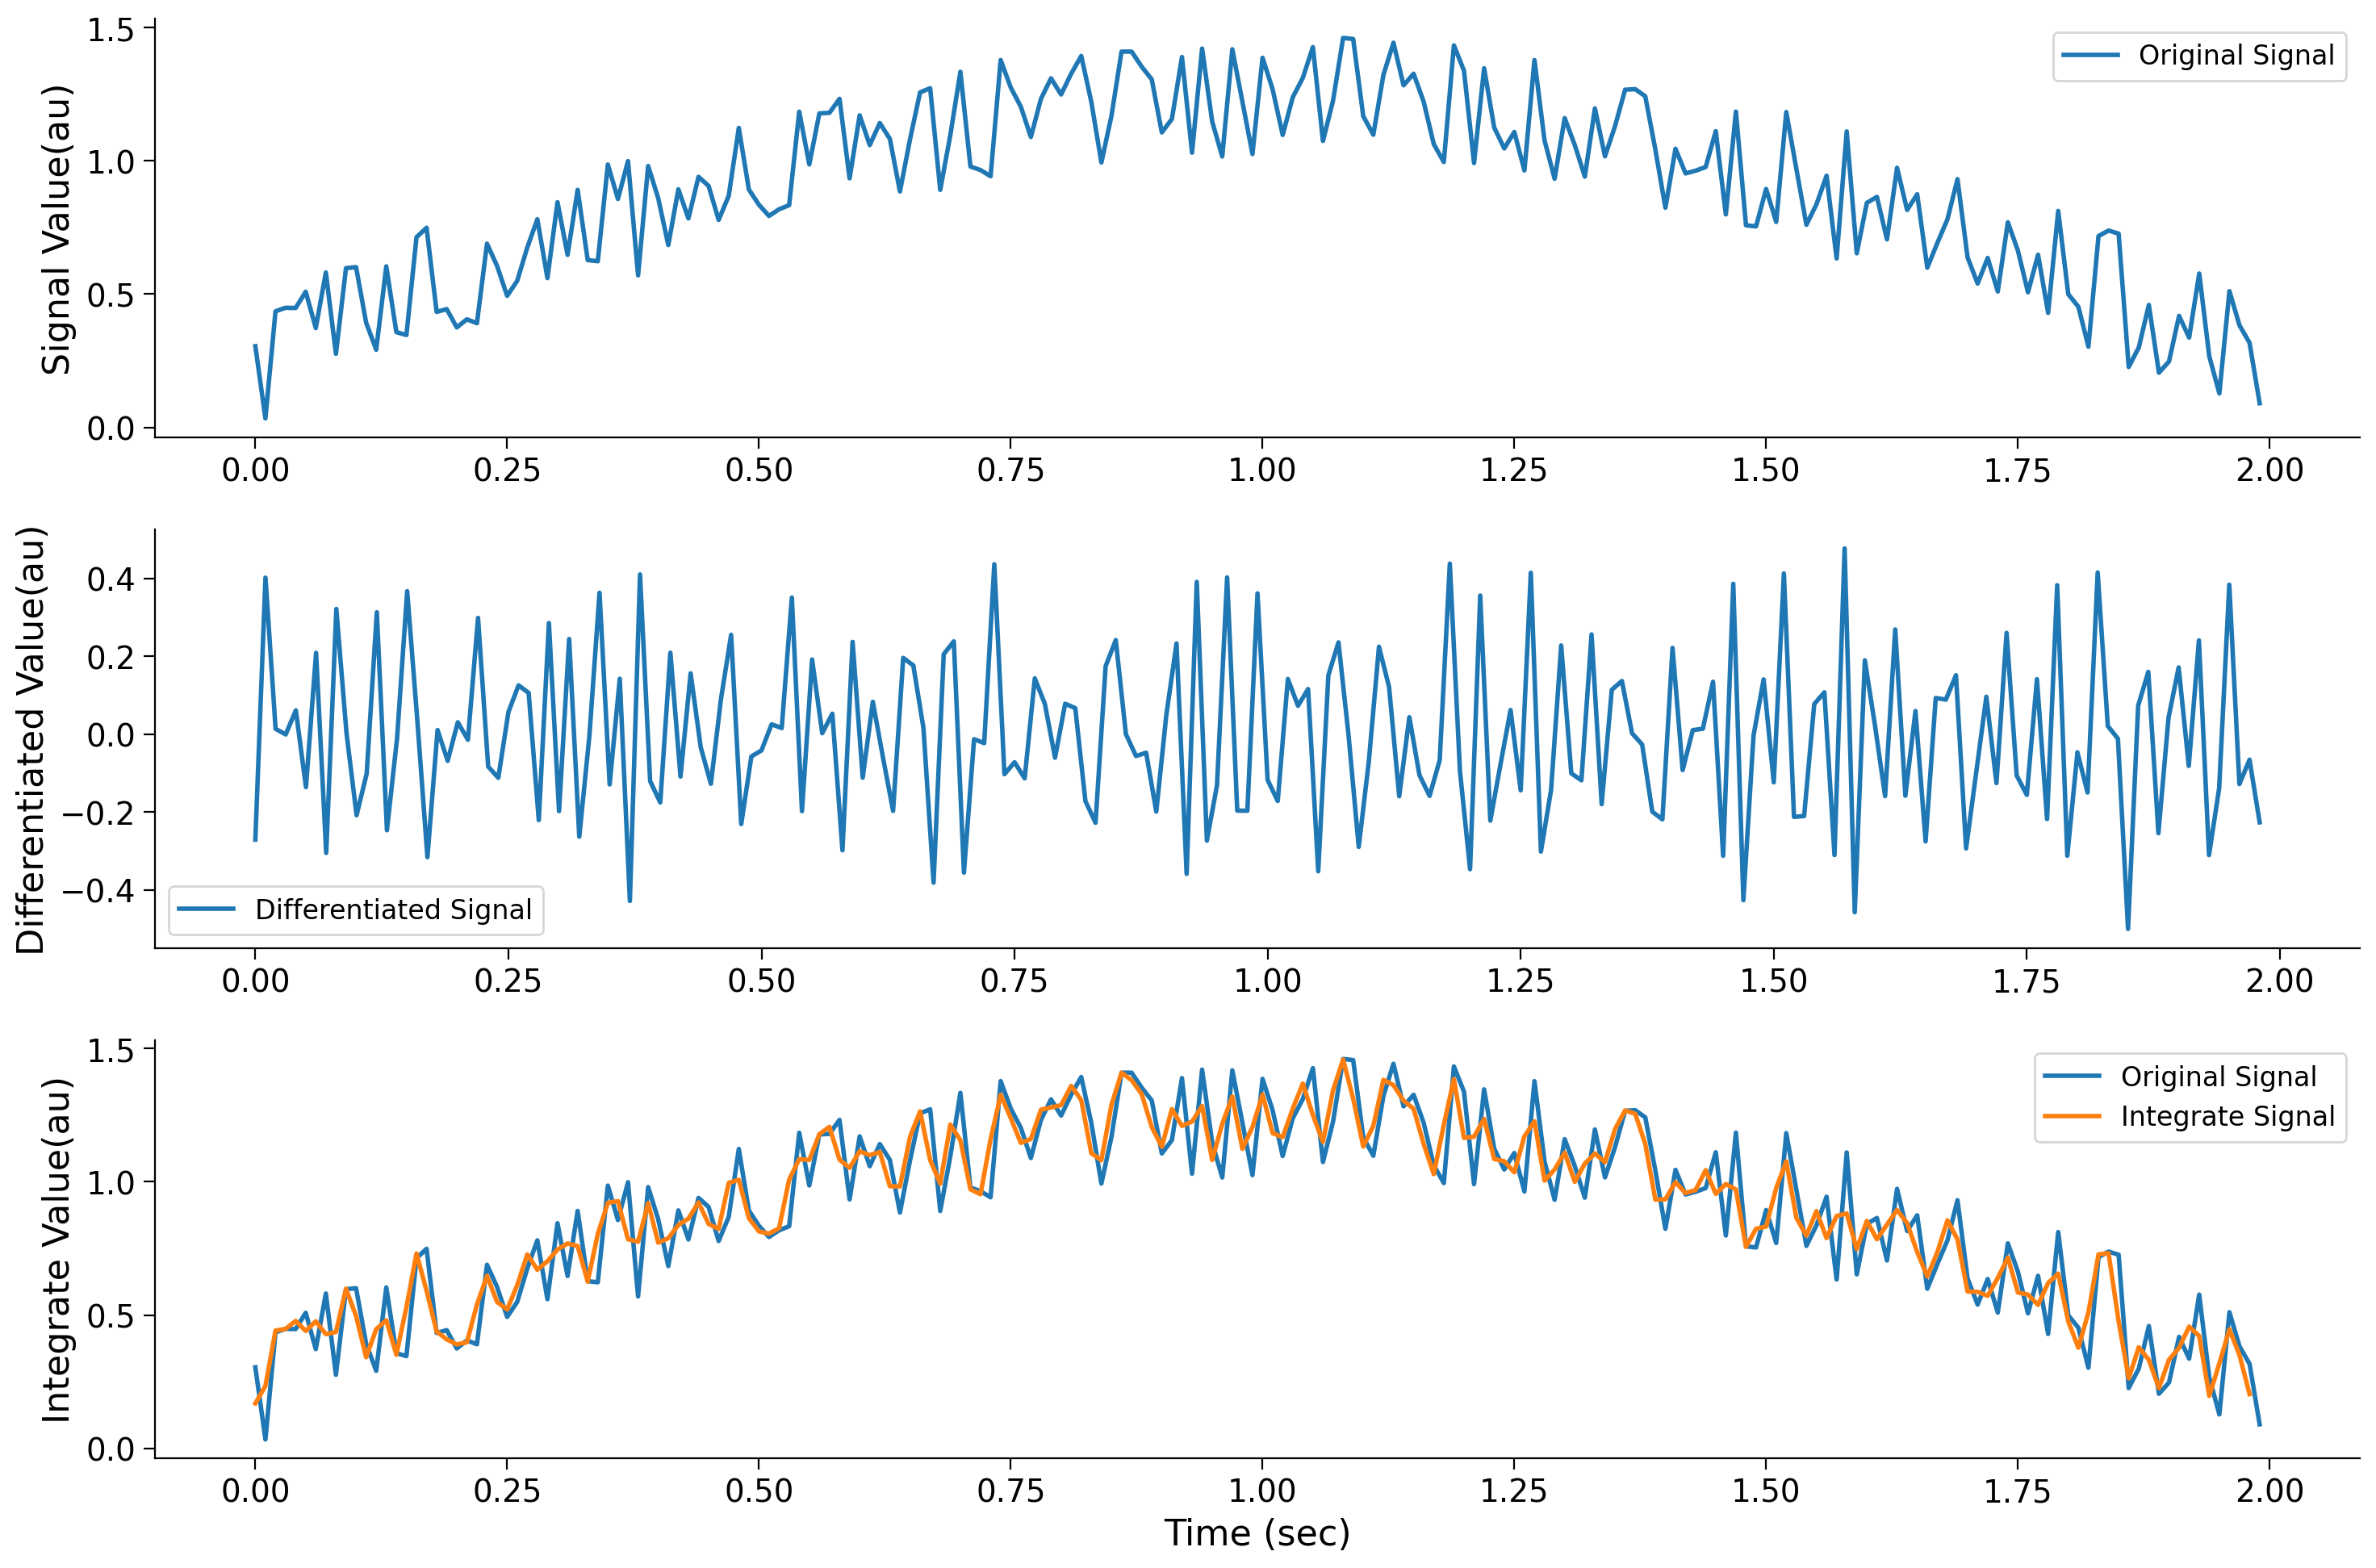

In [11]:
# @markdown Execute this cell to see visualization
h = 0.01
tx = np.arange(0,2,h)
noise_signal = np.random.uniform(0, 1, (len(tx)))*0.5
x1 = np.sin(0.5*np.pi*tx) + noise_signal # This will generate a 1 Hz sin wave
# In the signal x1 we have added random noise which contributs the high frequencies

# Take the derivative equivalent of the signal i.e. subtract the adjacent values
x1_diff = (x1[1:] - x1[:-1])

# Take the integration equivalent of the signal i.e. sum the adjacent values. And divide by 2 (take average essentially)
x1_integrate = (x1[1:] + x1[:-1])/2

# Plotting code
plt.figure(figsize=(15,10))
plt.subplot(3,1,1)
plt.plot(tx,x1,label='Original Signal')
#plt.xlabel('Time (sec)')
plt.ylabel('Signal Value(au)')
plt.legend()

plt.subplot(3,1,2)
plt.plot(tx[0:-1],x1_diff,label='Differentiated Signal')
# plt.xlabel('Time (sec)')
plt.ylabel('Differentiated Value(au)')
plt.legend()

plt.subplot(3,1,3)
plt.plot(tx,x1,label='Original Signal')
plt.plot(tx[0:-1],x1_integrate,label='Integrate Signal')
plt.xlabel('Time (sec)')
plt.ylabel('Integrate Value(au)')
plt.legend()

#### Demo 3: Parameter Change in ODE

In [14]:
my_layout.width = '450px'
@widgets.interact(
    alpha=widgets.FloatSlider(.3, min=-1., max=1., step=.1, layout=my_layout)
)
def Pop_widget(alpha):
  plot_dPdt(alpha=alpha)
  plt.show()

interactive(children=(FloatSlider(value=0.3, description='alpha', layout=Layout(width='450px'), max=1.0, min=-…

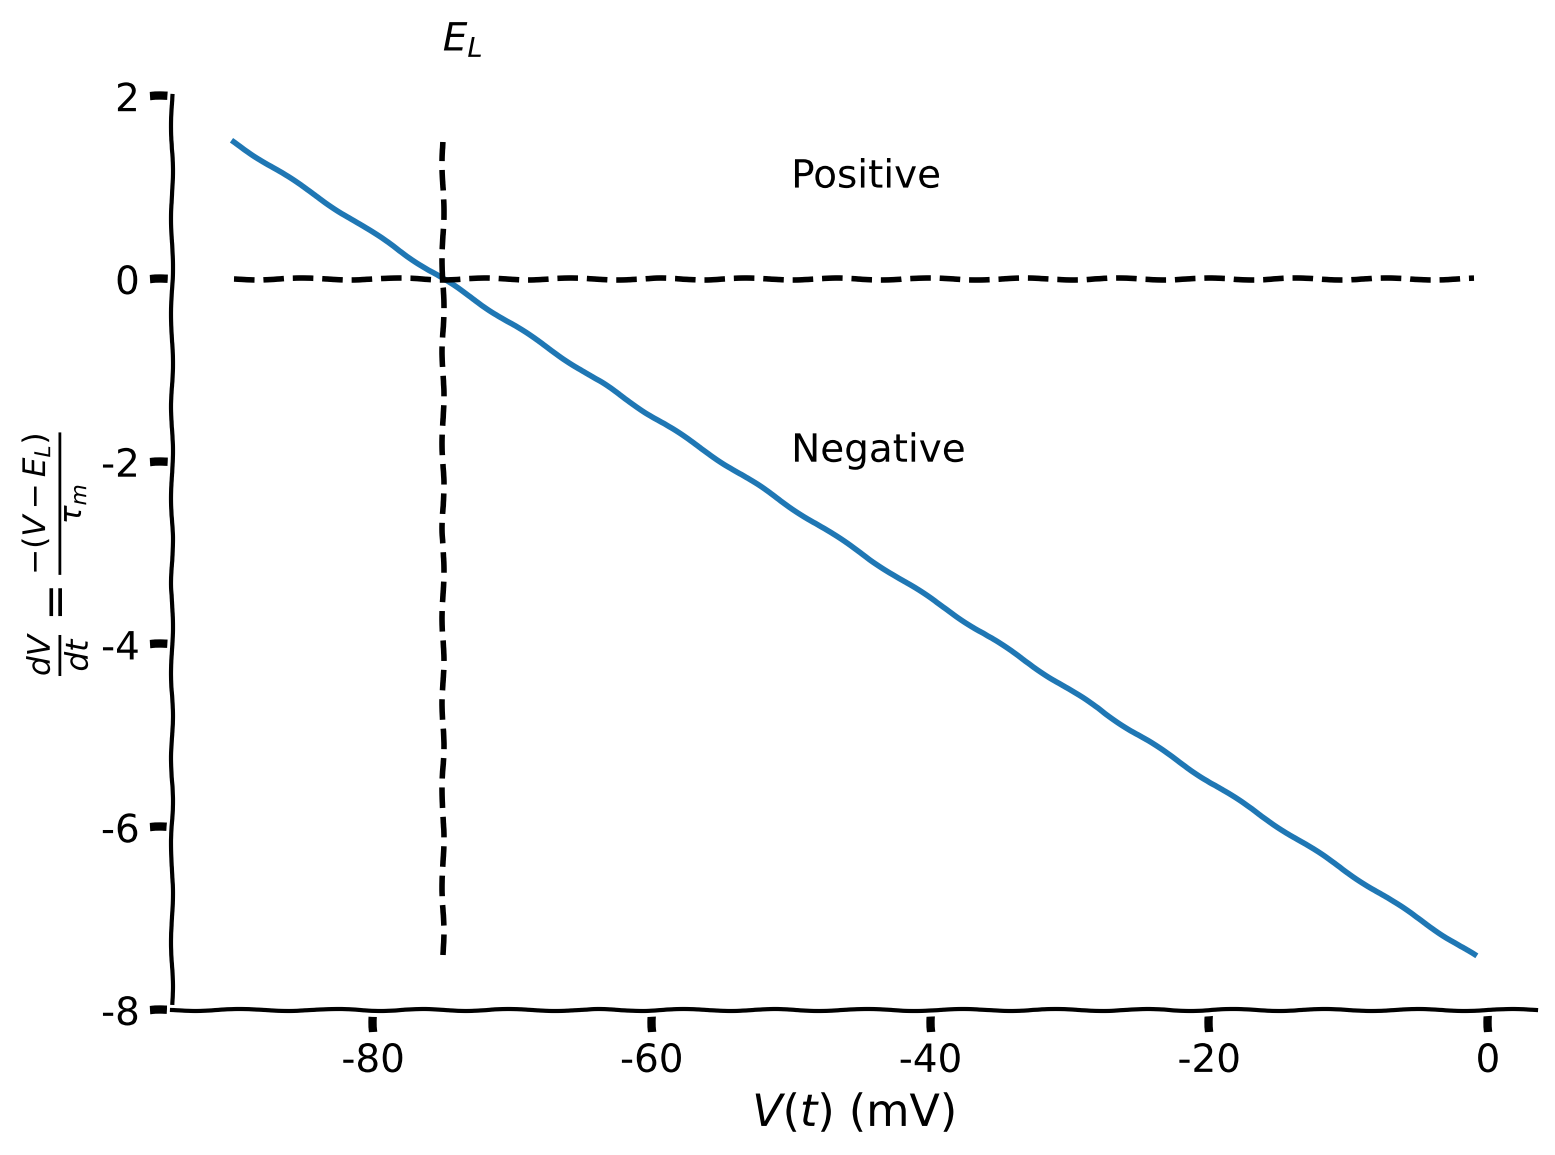

In [16]:
# @markdown Make sure you execute this cell to plot the relationship between dV/dt and V
# Parameter definition
E_L = -75
tau_m = 10

# Range of Values of V
V = np.arange(-90, 0, 1)
dV = -(V - E_L) / tau_m

with plt.xkcd():

  fig = plt.figure(figsize=(8, 6))
  plt.plot(V, dV)
  plt.hlines(0, min(V), max(V), colors='black', linestyles='dashed')
  plt.vlines(-75, min(dV), max(dV), colors='black', linestyles='dashed')

  plt.text(-50, 1, 'Positive')
  plt.text(-50, -2, 'Negative')
  plt.text(E_L, max(dV) + 1, r'$E_L$')
  plt.xlabel(r'$V(t)$ (mV)')
  plt.ylabel(r'$\frac{dV}{dt}=\frac{-(V-E_L)}{\tau_m}$')
  plt.ylim(-8, 2)
  plt.show()

In [17]:
my_layout.width = '450px'
@widgets.interact(
  V_reset=widgets.FloatSlider(-77., min=-91., max=-61., step=2,
                              layout=my_layout)
)

def V_reset_widget(V_reset):
  plot_V_no_input(V_reset)

interactive(children=(FloatSlider(value=-77.0, description='V_reset', layout=Layout(width='450px'), max=-61.0,…

In [ ]:
dt=0.1/1000
t=np.arange(0, 3, dt)

my_layout.width = '450px'
@widgets.interact(
    freq=widgets.FloatSlider(4, min=0.5, max=10., step=0.5,
                                layout=my_layout)
)

def Pop_widget(freq):
    s = np.sin(freq * 2*np.pi * t)

    x, y = Euler_Stuart_Landau(s, t, dt, lamba=1, gamma=.1, k=50)
    plot_Stuart_Landa(t, x, y, s)

interactive(children=(FloatSlider(value=4.0, description='freq', layout=Layout(width='450px'), max=10.0, min=0…